# Convolutional Neural Networks (CNN) in PyTorch
## 教學目標
- 幫助同學學會使用 PyTorch 建立自己的 CNN
- 幫助同學學會建立自己的 [PyTorch Dataset](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html)

## 適用對象
- 適用於具備 PyTorch 基礎，且已經掌握深度學習 script 中需要有哪些組件的學生。
- 已經對`梯度下降`、`反向傳播法`、`卷積神經網路`理論有認知的學生。

## 本教學使用的資料集
- [TinyImageNet](https://www.kaggle.com/datasets/akash2sharma/tiny-imagenet)，是一個小規模的 ImageNet 資料集：

||訓練集 (Training Set) |驗證集 (Validation Set) |測試集 (Test Set)|
|-|-|-|-|
|影像數量|100,000|10,000|10,000|
|有標註嗎？|有|有|無|
|影像有依照類別分資料夾？|有|無|x|

## 下載資料

In [1]:
# 從 Kaggle 下載資料
# -o 代表輸出的位置

!curl -L -o tiny-imagenet.zip\
  https://www.kaggle.com/api/v1/datasets/download/akash2sharma/tiny-imagenet

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  474M  100  474M    0     0  20.7M      0  0:00:22  0:00:22 --:--:-- 22.5M


In [2]:
# 解壓縮
# -q 代表不印出處理的資訊

!unzip -q tiny-imagenet.zip

## 觀察資料
```
tiny-imagenet-200/
    ├── test/
    ├── tiny-imagenet-200/
    │   ├── test/
    │   ├── train/
    │   ├── val/
    │   ├── wnids.txt
    │   └── words.txt
    ├── train/
    ├── val/
    │   ├── images/
    │   └── val_annotations.txt
    ├── wnids.txt
    └── words.txt
```

## 主程式

In [3]:
import torch
import torch.nn as nn
import torchvision
import os
from PIL import Image
from typing import Callable, Optional

from utils import train_epoch, do_eval, plot_loss_history

### 定義超參數

In [4]:
LR = 7e-4
TRAIN_BS = 128
TEST_BS = 512
NUM_EPOCHS = 5
MODEL_NAME = "simpleCNN" # "simpleCNN" or "resnet-18"

### 建立 CNN 模型
- 以下提供完全一樣的兩種寫法
- 影像在進行每層 convolution 後的 feature map 大小公式 (本公式中的 padding 為 0 或 1)：
$$
\mathrm{output\_size} = \frac{\mathrm{input\_size} - \mathrm{kernel\_size} + 2*\mathrm{padding}}{\mathrm{stride}} + 1
$$

In [5]:
class SimpleCNN(torch.nn.Module):
    """寫法1: 模型傳遞流程寫在 forward
    """      #在別處也能用
    def __init__(self, num_classes=10, fc_hidden_size=256, dropout_ratio=0.5):
        super().__init__()
                    #彩色一定是in_channel=3 filter大小
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
                   #in 拿上一層的輸出
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) # 2x2 pooling

        self.fc1 = nn.Linear(128 * 8 * 8, fc_hidden_size)
        self.fc2 = nn.Linear(fc_hidden_size, num_classes)
        self.relu = nn.ReLU() # 非線性轉換

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, x):
        # TinyImageNet 影像大小為 64x64
        x = self.pool(self.relu(self.conv1(x)))       # shape: (B, 64, 32, 32)
        # conv1: output_size = (64 - 3 + 2 * 1) / 1 + 1 = 64
        # pooling: output_size = (64 - 3 + 2 * 0) / 2 + 1 = 31.5 (進位為 32)

        x = self.pool(self.relu(self.conv2(x)))       # shape: (B, 64, 16, 16)
        # conv2: output_size = (32 - 3 + 2 * 1) / 1 + 1 = 32
        # pooling: output_size = (32 - 3 + 2 * 0) / 2 + 1 = 15.5 (進位為 16)

        x = self.pool(self.relu(self.conv3(x)))       # shape: (B, 128, 8, 8)
        # conv3: output_size = (16 - 3 + 2 * 1) / 1 + 1 = 16
        # pooling: output_size = (16 - 3 + 2 * 0) / 2 + 1 = 7.5 (進位為 8)

        x = x.view(x.size(0), -1)                     # Flatten, shape: (B, 128*8*8)
        x = self.dropout(self.relu(self.fc1(x)))      # shape: (B, 256)
        x = self.fc2(x)                               # shape: (B, 10)
        return x

In [6]:
class SimpleCNN(torch.nn.Module):
    """寫法2: 模型傳遞流程用 `nn.Sequential` 包起來
    """
    def __init__(self, num_classes=10, fc_hidden_size=256, dropout_ratio=0.5):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 8 * 8, fc_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_ratio),
            nn.Linear(fc_hidden_size, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

### 定義 transforms

In [7]:
if MODEL_NAME == "resnet-18":
    transform = torchvision.transforms.Compose([
        # transforms.RandomHorizontalFlip(),
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),  # (HWC, uint8) → (CHW, float32 [0,1])
        torchvision.transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
else:
    transform = torchvision.transforms.Compose([
        # transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),  # (HWC, uint8) → (CHW, float32 [0,1])
        torchvision.transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])

### 建立 PyTorch Dataset

In [8]:
def get_label_id(filename: str = "tiny-imagenet-200/wnids.txt") -> dict:
    with open(filename, "r") as f:
        word_list = f.read().splitlines()

    word_to_label_id = {}
    for label_id, word in enumerate(word_list):
        word_to_label_id[word] = label_id

    return word_to_label_id

In [9]:
class TinyImgNetDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        root_dir: str,
        transform: Optional[Callable[[Image.Image], torch.Tensor]] = None,
    ):
        """
        root_dir: 資料夾路徑，例如 'tiny-imagenet-200/tiny-imagenet-200/train'
        transform: torchvision.transforms 用來轉換 PIL 圖片
        """
        self.transform = transform
        self.image_paths = []
        self.word_to_label_id = get_label_id()
        self.labels = []

        class_names = sorted(os.listdir(root_dir))
        for _, class_name in enumerate(class_names):
            label_id = self.word_to_label_id[class_name]
            class_folder = os.path.join(root_dir, class_name , "images")
            if not os.path.isdir(class_folder):
                # 防止取到不是資料夾的位址
                continue

            for filename in os.listdir(class_folder):
                if filename.endswith(".JPEG"):
                    self.image_paths.append(os.path.join(class_folder, filename))
                    self.labels.append(label_id)

    def __getitem__(self, idx: int):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')  # 讀成 RGB 模式

        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.image_paths)

### 建立 PyTorch Dataset (ImageFolder)
- 我們只使用 `tiny-imagenet-200` 中的 `train` 資料夾
- 並且將資料切分為
    - **80000** (`training set`)
    - **10000** (`validation set`)
    - **10000** (`test set`)

In [10]:
data_dir = "tiny-imagenet-200/tiny-imagenet-200"
full_dataset = TinyImgNetDataset(f"{data_dir}/train", transform=transform)

generator1 = torch.Generator().manual_seed(42)
train_data, val_data, test_data = torch.utils.data.random_split(
    dataset=full_dataset,
    lengths=[80000, 10000, 10000],
    generator=generator1,
)

### 建立 DataLoader

In [11]:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=TRAIN_BS,
    shuffle=True,
)
val_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=TEST_BS,
    shuffle=False,
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=TEST_BS,
    shuffle=False,
)

### 設定 PyTorch 執行設備

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### 初始化模型、損失函數、optimizer

In [13]:
if MODEL_NAME == "resnet-18":
    model = torchvision.models.resnet18(pretrained=True)
    model.fc = torch.nn.Linear(512, 200)
elif MODEL_NAME == "simpleCNN":
    model = SimpleCNN(num_classes=200).to(device)
model.to(device) # 將模型移至 GPU

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

### 訓練與驗證模型

Evaluating: 100%|██████████| 20/20 [00:06<00:00,  2.99it/s]



Epoch 1/5 | Train Loss: 4.9523 | Val Loss: 4.5220 | Val Acc: 0.0837


Evaluating: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]



Epoch 2/5 | Train Loss: 4.3708 | Val Loss: 4.0011 | Val Acc: 0.1515


Evaluating: 100%|██████████| 20/20 [00:06<00:00,  3.19it/s]



Epoch 3/5 | Train Loss: 4.0465 | Val Loss: 3.7362 | Val Acc: 0.1948


Evaluating: 100%|██████████| 20/20 [00:05<00:00,  3.42it/s]



Epoch 4/5 | Train Loss: 3.8601 | Val Loss: 3.6687 | Val Acc: 0.1983


Evaluating: 100%|██████████| 20/20 [00:06<00:00,  3.12it/s]



Epoch 5/5 | Train Loss: 3.7300 | Val Loss: 3.5037 | Val Acc: 0.2243


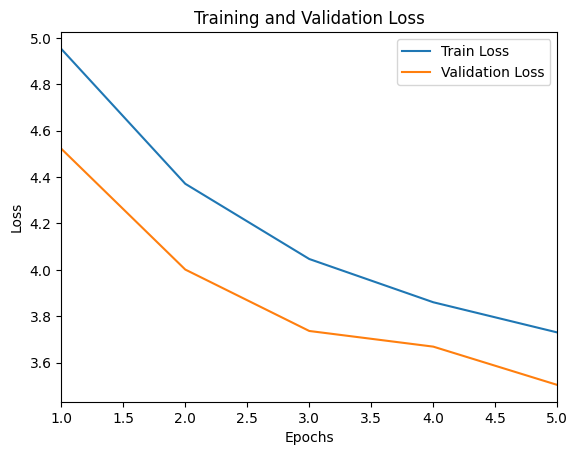

In [14]:
train_losses, val_losses = [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    train_loss_epoch = train_epoch(
        model=model,
        data_loader=train_loader,
        optimizer=optimizer,
        loss_fn=criterion,
        device=device,
    )
    train_losses.append(train_loss_epoch)

    # 驗證模型
    val_loss, val_acc, _, _ = do_eval(
        model=model,
        data_loader=val_loader,
        loss_fn=criterion,
        device=device,
    )
    val_losses.append(val_loss)

    print()
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {train_loss_epoch:.4f} | "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

# 繪製 loss 的歷史記錄圖
plot_loss_history(train_losses, val_losses, save_name="loss.png")